# Ultimate Inc. Take Home Challenge
# Michael Phillips

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Part 1 - Exploratory Data Analysis

In [2]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df['login_time'] = pd.to_datetime(df['login_time'], format='%Y/%m/%d %H:%M:%S')
df.set_index(df['login_time'], inplace=True)
df['count'] = 1
df.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [5]:
df1 = df.resample('15T').sum()

In [6]:
df1 = df1.reset_index()

In [7]:
df1['Date'] = df1['login_time'].dt.date
df1['Time'] = df1['login_time'].dt.time
df1['dayofweek'] = df1['login_time'].dt.dayofweek

df1.head()

,login_time,count,Date,Time,dayofweek
0,1970-01-01 20:00:00,2.0,1970-01-01,20:00:00,3
1,1970-01-01 20:15:00,6.0,1970-01-01,20:15:00,3
2,1970-01-01 20:30:00,9.0,1970-01-01,20:30:00,3
3,1970-01-01 20:45:00,7.0,1970-01-01,20:45:00,3
4,1970-01-01 21:00:00,1.0,1970-01-01,21:00:00,3


In [8]:
pivot_counts = df1.pivot_table(index=['Time'], values=['count'], aggfunc=np.mean)
pivot_counts.head()

,count
Time,
00:00:00,14.107843
00:15:00,15.166667
00:30:00,14.950980
00:45:00,14.529412
01:00:00,15.186275


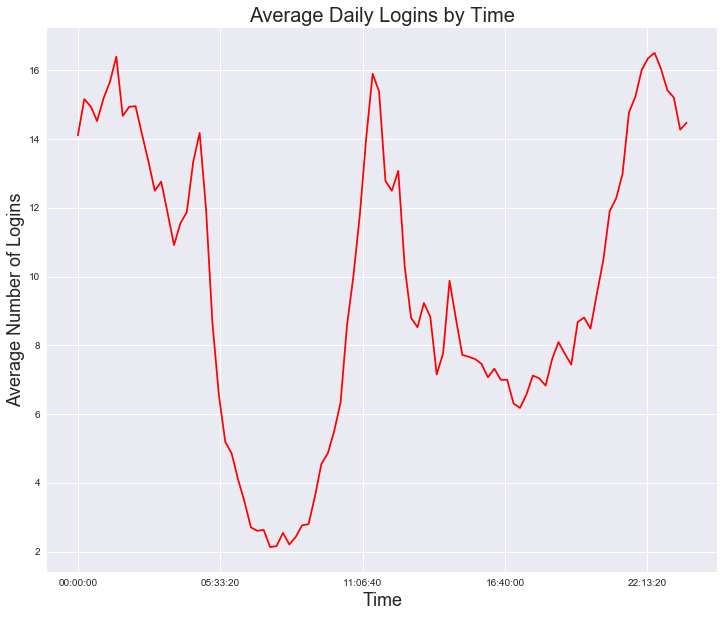

In [9]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes()

ax.plot(pivot_counts, color='red')

plt.title("Average Daily Logins by Time", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Average Number of Logins", fontsize=18)

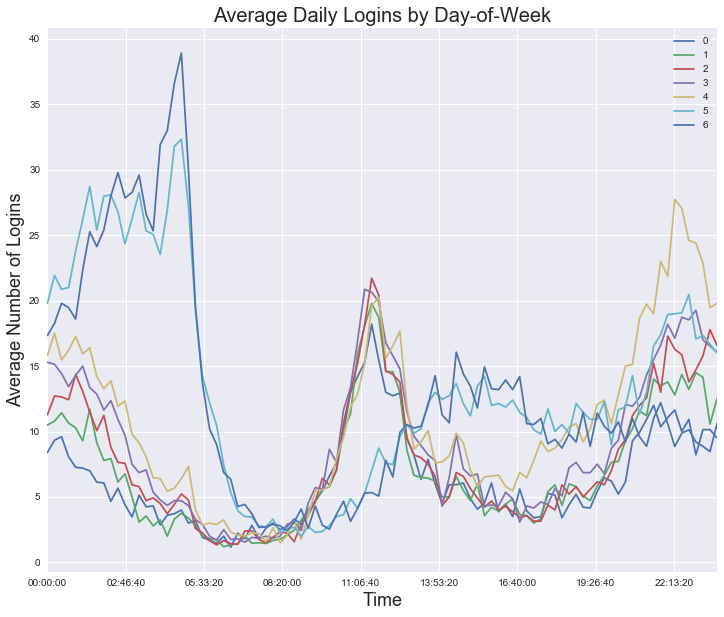

In [10]:
pivoted = pd.pivot_table(df1, values='count', columns='dayofweek', index='Time')


ax = pivoted.plot(figsize=(12,10))


lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.title("Average Daily Logins by Day-of-Week", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Average Number of Logins", fontsize=18)

# Part 2 - Experiment and Metric Design

# Part 3 - Predictive Modeling

In [11]:
import json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [12]:
print(df['signup_date'].min())
print(df['signup_date'].max())

2014-01-01
2014-01-31


In [13]:
print(df['last_trip_date'].min())
print(df['last_trip_date'].max())

2014-01-01
2014-07-01


In [14]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
def is_retained(date):
    
    start = pd.to_datetime('2014-6-1')
    end = pd.to_datetime('2014-7-1')
    if date <= end and date >= start:
        return 1
    else:
        return 0

In [17]:
df['retained_user'] = df['last_trip_date'].apply(is_retained)

In [18]:
(df.retained_user.sum()) / len(df)

0.37608

37.61% of users were 'retained' according to the metrics described in the notes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D656095630>]], dtype=object)

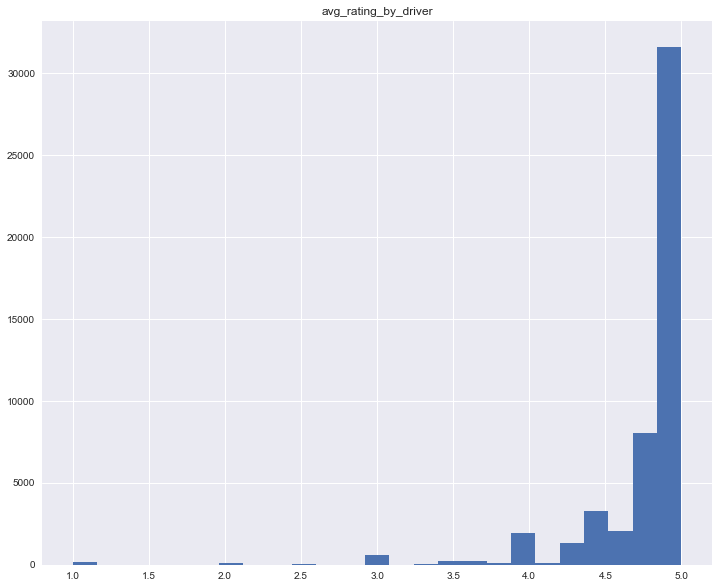

In [42]:
df.hist(column='avg_rating_by_driver', bins=25, figsize=(12,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D656202160>]], dtype=object)

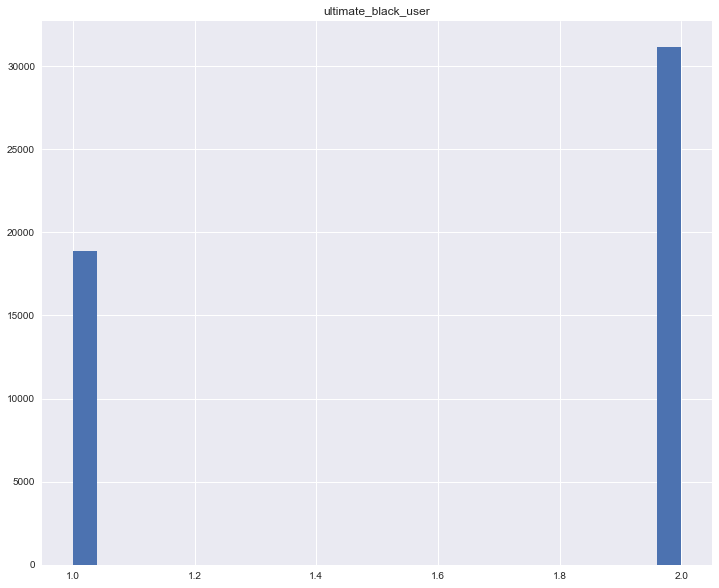

In [41]:
df.hist(column='ultimate_black_user', bins=25, figsize=(12,10))

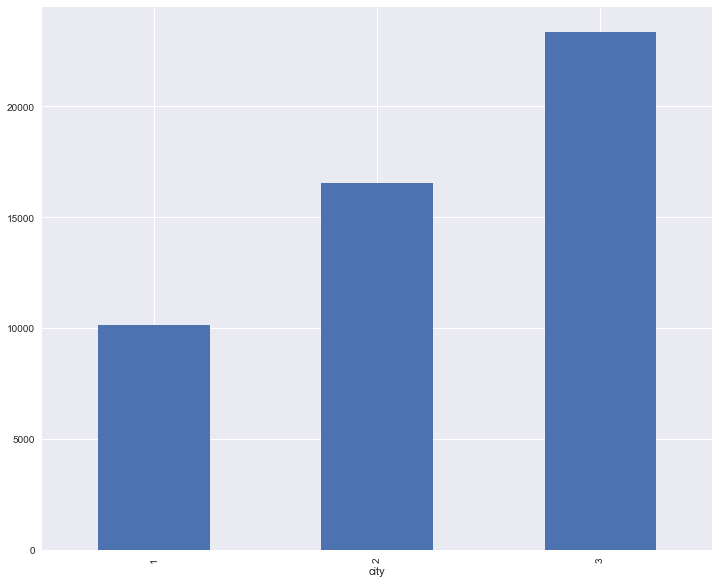

In [43]:
pivot_counts = df.groupby(['city']).count()
pivot_counts['avg_dist'].plot(kind='bar', figsize=(12,10))

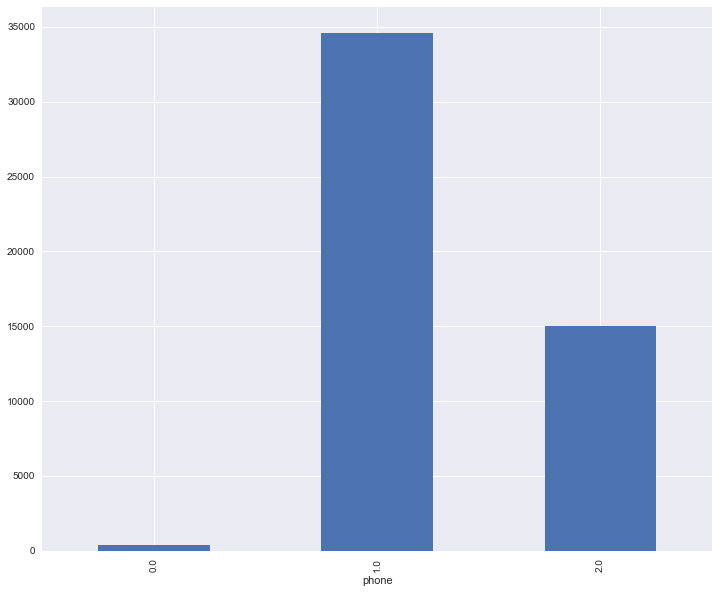

In [44]:
pivot_counts = df.groupby(['phone']).count()
pivot_counts['avg_dist'].plot(kind='bar', figsize=(12,10))

In [23]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [24]:
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)

In [25]:
def city_map(city):
    if city == "King's Landing":
        return 1
    elif city == "Astapor":
        return 2
    elif city == "Winterfell":
        return 3    

In [26]:
df['city'] = df['city'].apply(city_map)

In [27]:
def phone_map(phone):
    if phone == "iPhone":
        return 1
    elif phone == "Android":
        return 2

In [28]:
df['phone'] = df['phone'].apply(phone_map)

In [29]:
def ultimate_user(user):
    if user == True:
        return 1
    elif user == False:
        return 2

In [30]:
df['ultimate_black_user'] = df['ultimate_black_user'].apply(ultimate_user)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user
0,3.67,5.0,4.7,1.10,1,1.0,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,2,2.0,0.0,0,2,50.0,0
2,0.77,5.0,4.3,1.00,2,1.0,0.0,3,2,100.0,0
3,2.36,4.9,4.6,1.14,1,1.0,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,3,2.0,11.8,14,2,82.4,0


In [31]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
phone                      396
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
retained_user                0
dtype: int64

In [32]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [33]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna(0, inplace=True)

In [34]:
y = df['retained_user']
df.drop('retained_user', axis=1, inplace=True)

X = df.values

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats

In [36]:
sss = StratifiedShuffleSplit(test_size=0.25)
sss.get_n_splits(X,y)

10

In [37]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# create classifier and parameter dict for gridsearch
clf = RandomForestClassifier(n_jobs=-1,random_state=20)

parameters = {'n_estimators':[15,20,30,32,40],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split':[5,10,20,30,40]}

In [38]:
from sklearn.model_selection import GridSearchCV

# use gridsearch to find best parameters
CV_rfc = GridSearchCV(estimator=clf, param_grid=parameters, cv=sss)
CV_rfc.fit(X_train,y_train)

# create new classifier from best parameters
rfc = CV_rfc.best_estimator_

#predict from test set
pred = rfc.predict(X_test)

from sklearn.metrics import classification_report

# use class values to see how the model performed
print(classification_report(y_test, pred))
acc_score = (accuracy_score(y_test, pred) * 100)
print("The model predicts %.2f%% of users correctly." % acc_score)


             precision    recall  f1-score   support

          0       0.80      0.86      0.83      7799
          1       0.74      0.65      0.69      4701

avg / total       0.78      0.78      0.78     12500

The model predicts 78.17% of the games it tests correctly.


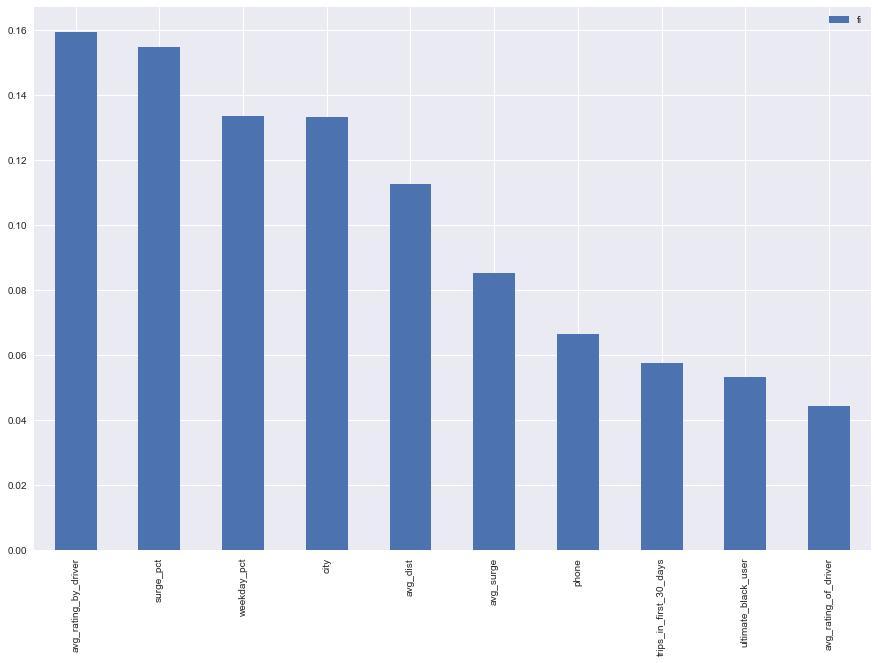

In [40]:
fi = rfc.feature_importances_
fi_df = pd.DataFrame({'fi':fi})

fi_names = list(df.columns.values)
fi_names_df = pd.DataFrame({'fi_names':fi_names})

fi_imp = fi_names_df.join(fi_df)
fi_imp = fi_imp.sort_values(by='fi',ascending=False)
fi_imp.reset_index(drop=True,inplace=True)
import matplotlib.pyplot as plt
%matplotlib inline
ax = fi_imp.plot(kind='bar',figsize=(15,10))
ax.set_xticklabels(fi_imp.fi_names);